In [6]:
import pandas as pd
from tensorflow.keras import models
from tensorflow.keras import layers 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('final_data.csv')

X = df.drop(columns=['readmitted'])
y=df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")


Training set size: 53216 samples
Test set size: 22808 samples


In [8]:
# Create the model with GridSearch
from sklearn.model_selection import GridSearchCV

#Define parameter grid
param_grid = { 
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [5, 10, 15]
}

model = RandomForestClassifier(random_state = 42)

# grid search over model using parameters in param_grid using 3-fold cross-validation (no need to pre-set validation sets),
# no parallel jobs running (speeds up process)
# verbosity level of output = 2
grid_search = GridSearchCV(estimator=model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose =2)
grid_result = grid_search.fit(X_train, y_train)

# print best parameter
print('Best parameters:', grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"{mean:.4f} (+/-{std:.4f}) with: {param}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': None, 'min_samples_split': 15, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.79      0.98      0.88     11433
           1       0.98      0.74      0.84     11375

    accuracy                           0.86     22808
   macro avg       0.88      0.86      0.86     22808
weighted avg       0.88      0.86      0.86     22808

0.8566 (+/-0.0019) with: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
0.8571 (+/-0.0023) with: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
0.8569 (+/-0.0023) with: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}
0.8572 (+/-0.0014) with: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
0.8574 (+/-0.0016) with: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
0.8574 (+/-0.0013) with: {'max_depth': None, 'min_samples_split': 10, 'n_estimat

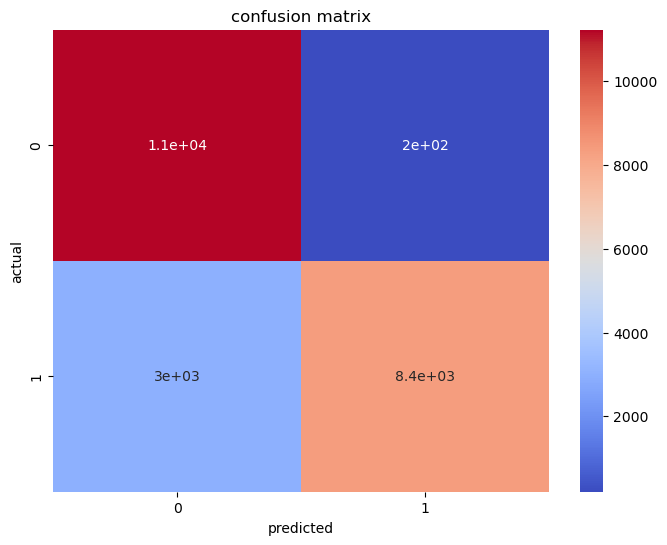

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap = 'coolwarm')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('actual')

plt.show()

# Confusion matrix shows we have no false positives (no one was predicted to be readmitted but actually never came in)
# We did have false negatives (predicted to not be readmitted but ended up being readmitted)
# For this model, we would prefer to have more false positives than false negatives. 

In [10]:
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

Precision: 0.9765816148199931


In [11]:
tp = cm[1,1]
tn = cm[0,0]
fp = cm[1,0]
fn = cm[0,1]

recall = tp / (tp + fn)
recall

0.9765816148199931

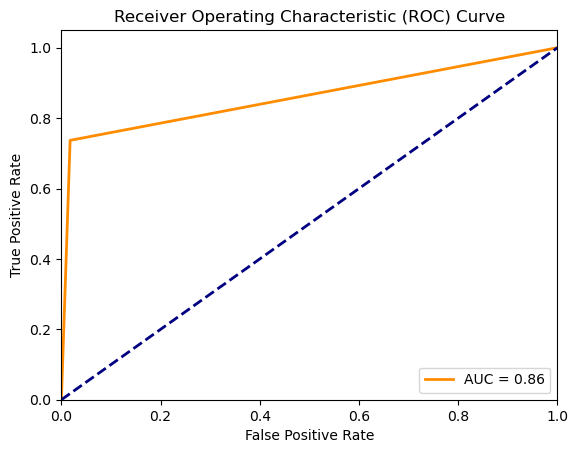

In [12]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()